In [23]:
import pandas as pd
import ete3
import re
import community
import networkx as nx
import itertools
import numpy as np
from sklearn import manifold
from scipy.spatial.distance import squareform, pdist
from matplotlib import pyplot as plt
import seaborn as sns
import igraph as ig
import plotly
import chart_studio.plotly as ptl
import plotly.graph_objects as go
import colorlover as cl
from IPython.display import HTML
import multiprocessing
import pickle as pkl
import random
from sklearn import mixture
from collections import Counter
import os
import subprocess
from scipy.stats import mannwhitneyu

ptl.sign_in('lthiberiol', 'm15ikp59lt')
ncbi = ete3.NCBITaxa()
%cd /work/eggNOG/

/work/eggNOG


In [2]:
sampled_genomes = pd.read_csv('/work/kelsey/genomes.tab',
                              sep='\t',
                              index_col=0)

In [3]:
lineages = pd.DataFrame()
for taxid in sampled_genomes.species_taxid.unique():
    if pd.isna(taxid):
        continue
    lineages = lineages.append({tax_rank: tmp_taxid 
                                 for tmp_taxid, tax_rank in ncbi.get_rank(ncbi.get_lineage(taxid)).items()},
                                ignore_index=True)
lineages = lineages.reindex(columns=['class', 'family',  'genus', 'phylum',
                                     'order', 'species', 'superkingdom']).copy()
lineages = lineages.query('superkingdom == 2').copy()

In [4]:
eggNOG_sample = pd.read_csv('e5.bacteria.taxid_info.tsv',
                            sep='\t',
                            comment='#',
                            names=['Taxid', 'Sci.Name', 'Rank', 'Named Lineage', 'Taxid Lineage'],
                            header=None,
                            index_col=0)

In [5]:
eggNOG_lineage = pd.DataFrame()
for taxid in eggNOG_sample.index.unique():
    if pd.isna(taxid):
        continue
    tmp = pd.Series({tax_rank: tmp_taxid 
                     for tmp_taxid, tax_rank in ncbi.get_rank(ncbi.get_lineage(taxid)).items()})
    tmp.name = taxid
    eggNOG_lineage = eggNOG_lineage.append(tmp)

eggNOG_lineage = eggNOG_lineage.reindex(columns=['class', 'family',  'genus', 'phylum',
                                                 'order', 'species', 'superkingdom']).copy()
eggNOG_lineage = eggNOG_lineage.query('superkingdom == 2').copy()

eggNOG_target_phyla = eggNOG_lineage[eggNOG_lineage.phylum.isin(lineages.phylum.unique())]

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 1344012 was translated into 480813

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 443255 was translated into 1901

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 1525715 was translated into 1545044

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 861530 was translated into 29382

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 1317118 was translated into 1379903

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 67281 was translated into 67351

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/

In [6]:
eggNOG_groups = pd.read_csv('2_members.tsv',
                            sep='\t',
                            header=None,
                            usecols=[1,2,3,4],
                            names=['group_id', 'num_proteins', 'num_taxa', 'members'])

tmp           = eggNOG_groups.members.map(lambda cell: [int(taxid) 
                                                        for taxid in re.findall('(\d+)\.(?:[^,]+)', cell)])
tmp.name      = 'taxa'
eggNOG_groups = eggNOG_groups.join(tmp)

In [7]:
def get_phyla_overlap(taxa):
    #taxids = [int(_) for _ in taxa]
    group_phyla = set(eggNOG_lineage.loc[taxa, 'phylum'].unique())
    overlapped_phyla = group_phyla.intersection(lineages.phylum.unique())
    return(overlapped_phyla)

eggNOG_target_groups = eggNOG_groups[eggNOG_groups.taxa.map(lambda cell: 
                                                            True if len(get_phyla_overlap(cell)) > 1 
                                                            else False)]

In [8]:
eggNOG_trees = pd.read_csv('2_trees.tsv',
                           sep='\t',
                           header=None,
                           usecols=[1,2,3],
                           index_col=0,
                           names=['group_id', 'fast', 'tree'])
eggNOG_trees = eggNOG_trees.reindex(index=eggNOG_target_groups.group_id)

In [9]:
eggNOG_chloroflexi = eggNOG_lineage.query('phylum==200795').index
eggNOG_cyano       = eggNOG_lineage.query('phylum==1117'  ).index

chloroflexi_count = eggNOG_target_groups.taxa.map(lambda x: len(eggNOG_chloroflexi.intersection(set(x))))
cyano_count       = eggNOG_target_groups.taxa.map(lambda x: len(eggNOG_cyano.intersection(set(x))))

In [10]:
def standardize_values(to_standardize):
    tmp  = np.array(to_standardize)
    tmp -= np.median(tmp)
    tmp /= (np.percentile(tmp, 75) - np.percentile(tmp, 25))
    
    return(tmp)

In [11]:
def get_pairwise_distances(group_id):
    
    tree = ete3.Tree(eggNOG_trees.loc[group_id, 'tree'])

    leaf_names = []
    for count, node in enumerate(tree.traverse()):
        if node.is_leaf():
            leaf_names.append(node.name)
        else:
            node.name = 'node_%i' % count
    leaf_names = np.array(leaf_names)

    nodes         = []
    children      = []
    branch_length = []
    for node in tree.traverse():
        if not node.is_leaf():
            for child in node.get_children():
                nodes.append(         node.name)
                children.append(     child.name)
                branch_length.append(child.dist)

    branch_length_df                  = pd.DataFrame()
    branch_length_df['node']          = nodes
    branch_length_df['child']         = children
    branch_length_df['branch_length'] = branch_length

    dag  = ig.Graph.TupleList(edges=branch_length_df[['node', 
                                                      'child', 
                                                      'branch_length']].itertuples(index=False), 
                                directed=False, 
                                weights=True)
    
    dist_matrix = pd.DataFrame(index  =leaf_names, 
                               columns=leaf_names, 
                               data   =np.array(dag.shortest_paths(source=leaf_names, 
                                                                   target=leaf_names, 
                                                                   weights='weight'))
                              )
    return(dist_matrix)

In [12]:
def create_taxa_graph(dist_matrix, phyla):
    triu_indices       = np.triu_indices_from(dist_matrix, k=1)
    
    edge_list                 = pd.DataFrame()
    edge_list['phylum1']      = phyla[triu_indices[0]]
    edge_list['phylum2']      = phyla[triu_indices[1]]
    edge_list['sequence1']    = dist_matrix.index[triu_indices[0]]
    edge_list['sequence2']    = dist_matrix.index[triu_indices[1]]
    edge_list['distance']     = dist_matrix.values[triu_indices]
    edge_list['inverse_dist'] = np.e**np.negative(edge_list.distance)

    graph  = ig.Graph.TupleList(edges=edge_list[['sequence1', 
                                                 'sequence2', 
                                                 'inverse_dist']].itertuples(index=False), 
                                directed=False, 
                                weights =True)
    
    return(edge_list, graph)

In [13]:
def extract_cluster(clusterID):
    group_id, cluster_num = clusterID.split('#')
    dist_matrix = get_pairwise_distances(group_id)

    taxids = [int(leaf.split('.')[0]) for leaf in dist_matrix.index]
    phyla  = eggNOG_lineage.loc[taxids, 'phylum'].values.astype(int)

    edge_list, graph  = create_taxa_graph(dist_matrix, phyla)

    random.seed(12345)
    clusters = graph.community_multilevel(weights='weight')

    node_data = pd.DataFrame(columns=['name', 'phylum', 'cluster'],
                             data   =zip(dist_matrix.index, 
                                         phyla, 
                                         clusters.membership)
                            )
    
    cluster_seqs = node_data.loc[node_data.cluster==int(cluster_num), 'name'].values
    
    if not os.path.isfile('alignment/%s' % group_id):
        subprocess.call(['curl', 
                         'http://eggnogapi5.embl.de/nog_data/text/raw_alg/%s' % group_id,
                         '--output', 'alignment/%s.gz' % group_id])
        subprocess.call(['gzip', '-d', 'alignment/%s.gz' % group_id])
    
    with open('alignment/%s' % group_id) as fasta_handle,\
         open('alignment/%s-cluster%s.faa' % (group_id, cluster_num), 'w') as out:
        for entry in fasta_handle.read().split('>'):
            if entry and entry.split()[0] in cluster_seqs:
                out.write('>%s' % entry)

In [14]:
def visualize_candidates(group_cluster):
    extract_cluster('COG0180#1')
    
    group_id, cluster_num = group_cluster.split('#')
    print('  %s' % (' '.join(['mafft', '--auto', '--reorder', 'alignment/%s-cluster%s.faa' % (group_id, cluster_num)])))
    print('  %s' % (' '.join(['/Users/thiberio/anaconda2/bin/FastTree',
                     '-gamma', 
                     '-wag', 
                     '-out', 'alignment/%s-cluster%s.tree' % (group_id, cluster_num), 
                     'alignment/%s-cluster%s.aln' % (group_id, cluster_num)])))
    
    with open('alignment/%s-cluster%s.aln' % (group_id, cluster_num), 'w') as out:
        subprocess.call(['mafft', '--auto', '--reorder', 'alignment/%s-cluster%s.faa' % (group_id, cluster_num)],
                        stdout=out)
        
    subprocess.call(['/Users/thiberio/anaconda2/bin/FastTree',
                     '-gamma', 
                     '-wag', 
                     '-out', 'alignment/%s-cluster%s.tree' % (group_id, cluster_num), 
                     'alignment/%s-cluster%s.aln' % (group_id, cluster_num)])
    
    tree = ete3.Tree('alignment/%s-cluster%s.tree' % (group_id, cluster_num), format=0)

    out  = open('%s-cluster%s.fastFigTree' % (group_id, cluster_num), 'w')
    out.write("#NEXUS\nbegin taxa;\n\tdimensions ntax=%i;\n\ttaxlabels\n" %len(tree))

    for node in tree.traverse():
        if node.is_leaf():
            taxid, locus_tag = node.name.split('.')
            try:
                lineage = {j: i for i, j in ncbi.get_rank(ncbi.get_lineage(taxid)).items()}
            except ValueError:
                out.write('\t%s\n' %(node.name))
                continue
            else:
                lineage_names = ncbi.get_taxid_translator(lineage.values())

            out.write('\t%s ' %(node.name))
            comment = []
            for rank in ['class', 'phylum', 'order', 'family', 'species']:
                if rank in lineage:
                    comment.append('tax_%s="%s"' %(rank, lineage_names[lineage[rank]]))
            out.write('[&%s]\n' %' '.join(comment))

    newick_text = tree.write(format=0)
    out.write(';\nend;\n')
    out.write('begin trees;\n\ttree tree_1 = [&R] %s\nend;' %newick_text)
    out.close()

In [20]:
def assess_cluster(reference_phylum, minimal_freq_phyla, cluster_edges):
    cluster_dists = pd.DataFrame(columns=['phylum', 'median', 'distances'])

    for phylum1, phylum2 in itertools.combinations(minimal_freq_phyla, 2):
        if   phylum1 == reference_phylum:
            phylum = phylum2
        elif phylum2 == reference_phylum:
            phylum = phylum1
        else:
            continue

        inter_phyla_dists = cluster_edges.loc[((cluster_edges.phylum1==phylum1)&(cluster_edges.phylum2==phylum2))|\
                                              ((cluster_edges.phylum2==phylum1)&(cluster_edges.phylum1==phylum2)), 
                                              'distance'].values

        try:
            phylum_3rd_quartile = np.median(inter_phyla_dists)
        except IndexError:
            continue        

        cluster_dists = cluster_dists.append(pd.Series(data=[phylum, phylum_3rd_quartile, inter_phyla_dists], 
                                           index=['phylum', 'median', 'distances']),
                                 ignore_index=True)

    return(cluster_dists)

In [139]:
def get_phyla_evol_distances(group_id):    
    dist_matrix = get_pairwise_distances(group_id)

    taxids = [int(leaf.split('.')[0]) for leaf in dist_matrix.index]
    phyla  = eggNOG_lineage.loc[taxids, 'phylum'].values.astype(int)

    edge_list, graph  = create_taxa_graph(dist_matrix, phyla)

    random.seed(12345)
    clusters = graph.community_multilevel(weights='weight')

    node_data = pd.DataFrame(columns=['name', 'phylum', 'cluster'],
                             data   =zip(dist_matrix.index, 
                                         phyla, 
                                         clusters.membership)
                            )

    family_cyano_count     = sum(node_data.phylum==1117)
    
    cluster_evol_relations = {}

    for cluster_num in set(clusters.membership):
        cluster_nodes = node_data[node_data.cluster==cluster_num]

        if sum(cluster_nodes.phylum==1117) < family_cyano_count*0.3:
            continue

        reciproc_cluster_dists = pd.DataFrame(columns=['phylum', 'median', 'distances'])
        
        cluster_edges = edge_list.loc[(edge_list.sequence1.isin(cluster_nodes.name))&
                                      (edge_list.sequence2.isin(cluster_nodes.name)),
                                      ['phylum1', 'phylum2', 'distance']]

        minimal_freq_phyla = [phylum for phylum, frequency in Counter(cluster_nodes.phylum).items() if frequency>=5 \
                                                                                                    and phylum > 0]
        cluster_edges      = cluster_edges[(cluster_edges.phylum1.isin(minimal_freq_phyla)) &\
                                           (cluster_edges.phylum2.isin(minimal_freq_phyla))]
        normalizer         = np.median(cluster_edges.distance)
        cluster_edges      = cluster_edges[cluster_edges.phylum1 != cluster_edges.phylum2] 

        #
        #
        #
        cluster_dists = assess_cluster(1117, 
                                       minimal_freq_phyla, 
                                       cluster_edges)
        
        cluster_dists.sort_values('median', inplace=True)
        cluster_evol_relations[cluster_num]                  = {'df':cluster_dists[['phylum', 'median']].copy(),
                                                                'significant':False}
        if not cluster_dists.shape[0]:
            continue

        cluster_evol_relations[cluster_num]['df']['median'] /= normalizer
        if cluster_dists.shape[0] == 1:
            cluster_evol_relations[cluster_num]['significant'] = True
            continue

        hypothesis = mannwhitneyu(cluster_dists.iloc[0, 2], 
                                  cluster_dists.iloc[1, 2], 
                                  alternative='less')
        effect_size = hypothesis.statistic / (len(cluster_dists.iloc[0, 2])*len(cluster_dists.iloc[1, 2]))
        
        if hypothesis.pvalue < 0.01 and effect_size < 0.2:
            cluster_evol_relations[cluster_num]['significant'] = True
    
    return(group_id, cluster_evol_relations)

In [140]:
%%time
test = get_phyla_evol_distances('COG0499')

CPU times: user 10.2 s, sys: 1.07 s, total: 11.3 s
Wall time: 11 s


In [141]:
test

('COG0499', {2: {'df':    phylum    median
   4  200795  0.513232
   7  200783  0.598979
   8  200940  0.618192
   5  508458  0.942521
   3    1239  0.992829
   6  200918  1.102292
   2  201174  1.455080
   1    1224  1.932858
   0     976  3.036359, 'significant': True}, 3: {'df':    phylum    median
   2    1224  0.877321
   1  203682  0.975939
   0     976  1.046242, 'significant': False}})

In [114]:
a, b = test[1][2]['df']
a['1st_quart'] = a.distances.apply(lambda x: np.percentile(x, 25))
b['1st_quart'] = b.distances.apply(lambda x: np.percentile(x, 25))

In [115]:
mannwhitneyu(a.iloc[0, 2], 
             a.iloc[1, 2], 
             alternative='less').statistic / \
(len(a.iloc[0, 2])*len(a.iloc[1, 2]))

0.1378066890495868

In [116]:
mannwhitneyu(b.iloc[0, 2], 
             b.iloc[1, 2], 
             alternative='less').statistic / \
(len(b.iloc[0, 2])*len(b.iloc[1, 2]))

0.3970982142857143

In [116]:
mannwhitneyu(test[1][0][1].iloc[0, 2], test[1][0][1].iloc[1, 2], alternative='less').statistic/\
(len(test[1][0][1].iloc[0, 2])*len(test[1][0][1].iloc[1, 2]))

0.6303849026490367

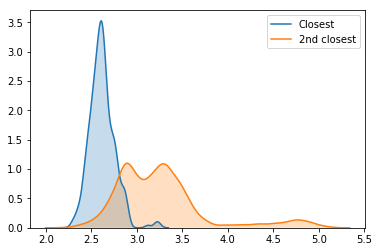

In [68]:
sns.kdeplot(test[1][0]['df'][0].iloc[0, 2], shade=True, label='Closest')
sns.kdeplot(test[1][0]['df'][0].iloc[9, 2], shade=True, label='2nd closest')

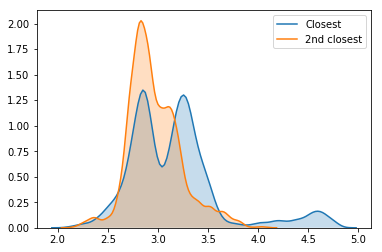

In [110]:
sns.kdeplot(test[1][0][1].iloc[0, 2], shade=True, label='Closest')
sns.kdeplot(test[1][0][1].iloc[1, 2], shade=True, label='2nd closest')

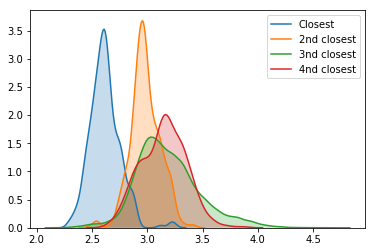

In [80]:
sns.kdeplot(test[1][0].iloc[0, 2], shade=True, label='Closest')
sns.kdeplot(test[1][0].iloc[1, 2], shade=True, label='2nd closest')
sns.kdeplot(test[1][0].iloc[2, 2], shade=True, label='3nd closest')
sns.kdeplot(test[1][0].iloc[3, 2], shade=True, label='4nd closest')

In [81]:
%%time
group_id = 'COG0073'
dist_matrix = get_pairwise_distances(group_id)

taxids = [int(leaf.split('.')[0]) for leaf in dist_matrix.index]
phyla  = eggNOG_lineage.loc[taxids, 'phylum'].values.astype(int)

edge_list, graph  = create_taxa_graph(dist_matrix, phyla)

random.seed(12345)
clusters = graph.community_multilevel(weights='weight')

node_data = pd.DataFrame(columns=['name', 'phylum', 'cluster'],
                         data   =zip(dist_matrix.index, 
                                     phyla, 
                                     clusters.membership)
                        )

family_cyano_count = sum(node_data.phylum==1117)

cluster_evol_relations = {}

CPU times: user 52.3 s, sys: 6.32 s, total: 58.6 s
Wall time: 57 s


In [82]:
set(clusters.membership)

{0, 1, 2, 3, 4, 5, 6, 7, 8}

In [ ]:
# groups interesting to test distances between cyano and chloroflexi
test_groups = eggNOG_target_groups[(chloroflexi_count>=10) & (cyano_count>=70)]

test_groups = test_groups[test_groups.num_proteins<10_000]
print(test_groups.shape)

In [20]:
%%time
pool    = multiprocessing.Pool(processes=5, maxtasksperchild=5)
results = pool.map_async(get_phyla_evol_distances, test_groups.group_id.values)
pool.close()
pool.join()

CPU times: user 6.13 s, sys: 46.5 s, total: 52.6 s
Wall time: 2h 2min 19s


In [153]:
with open('test_results.pkl', 'wb') as out:
    pkl.dump(results.get(), out)

COG0049#3
COG0073#0
COG0180#1
COG0310#0
COG0415#2
COG0499#2
COG0685#8
COG1304#5
COG1633#10
COG1666#3
COG2264#0
COG2324#2


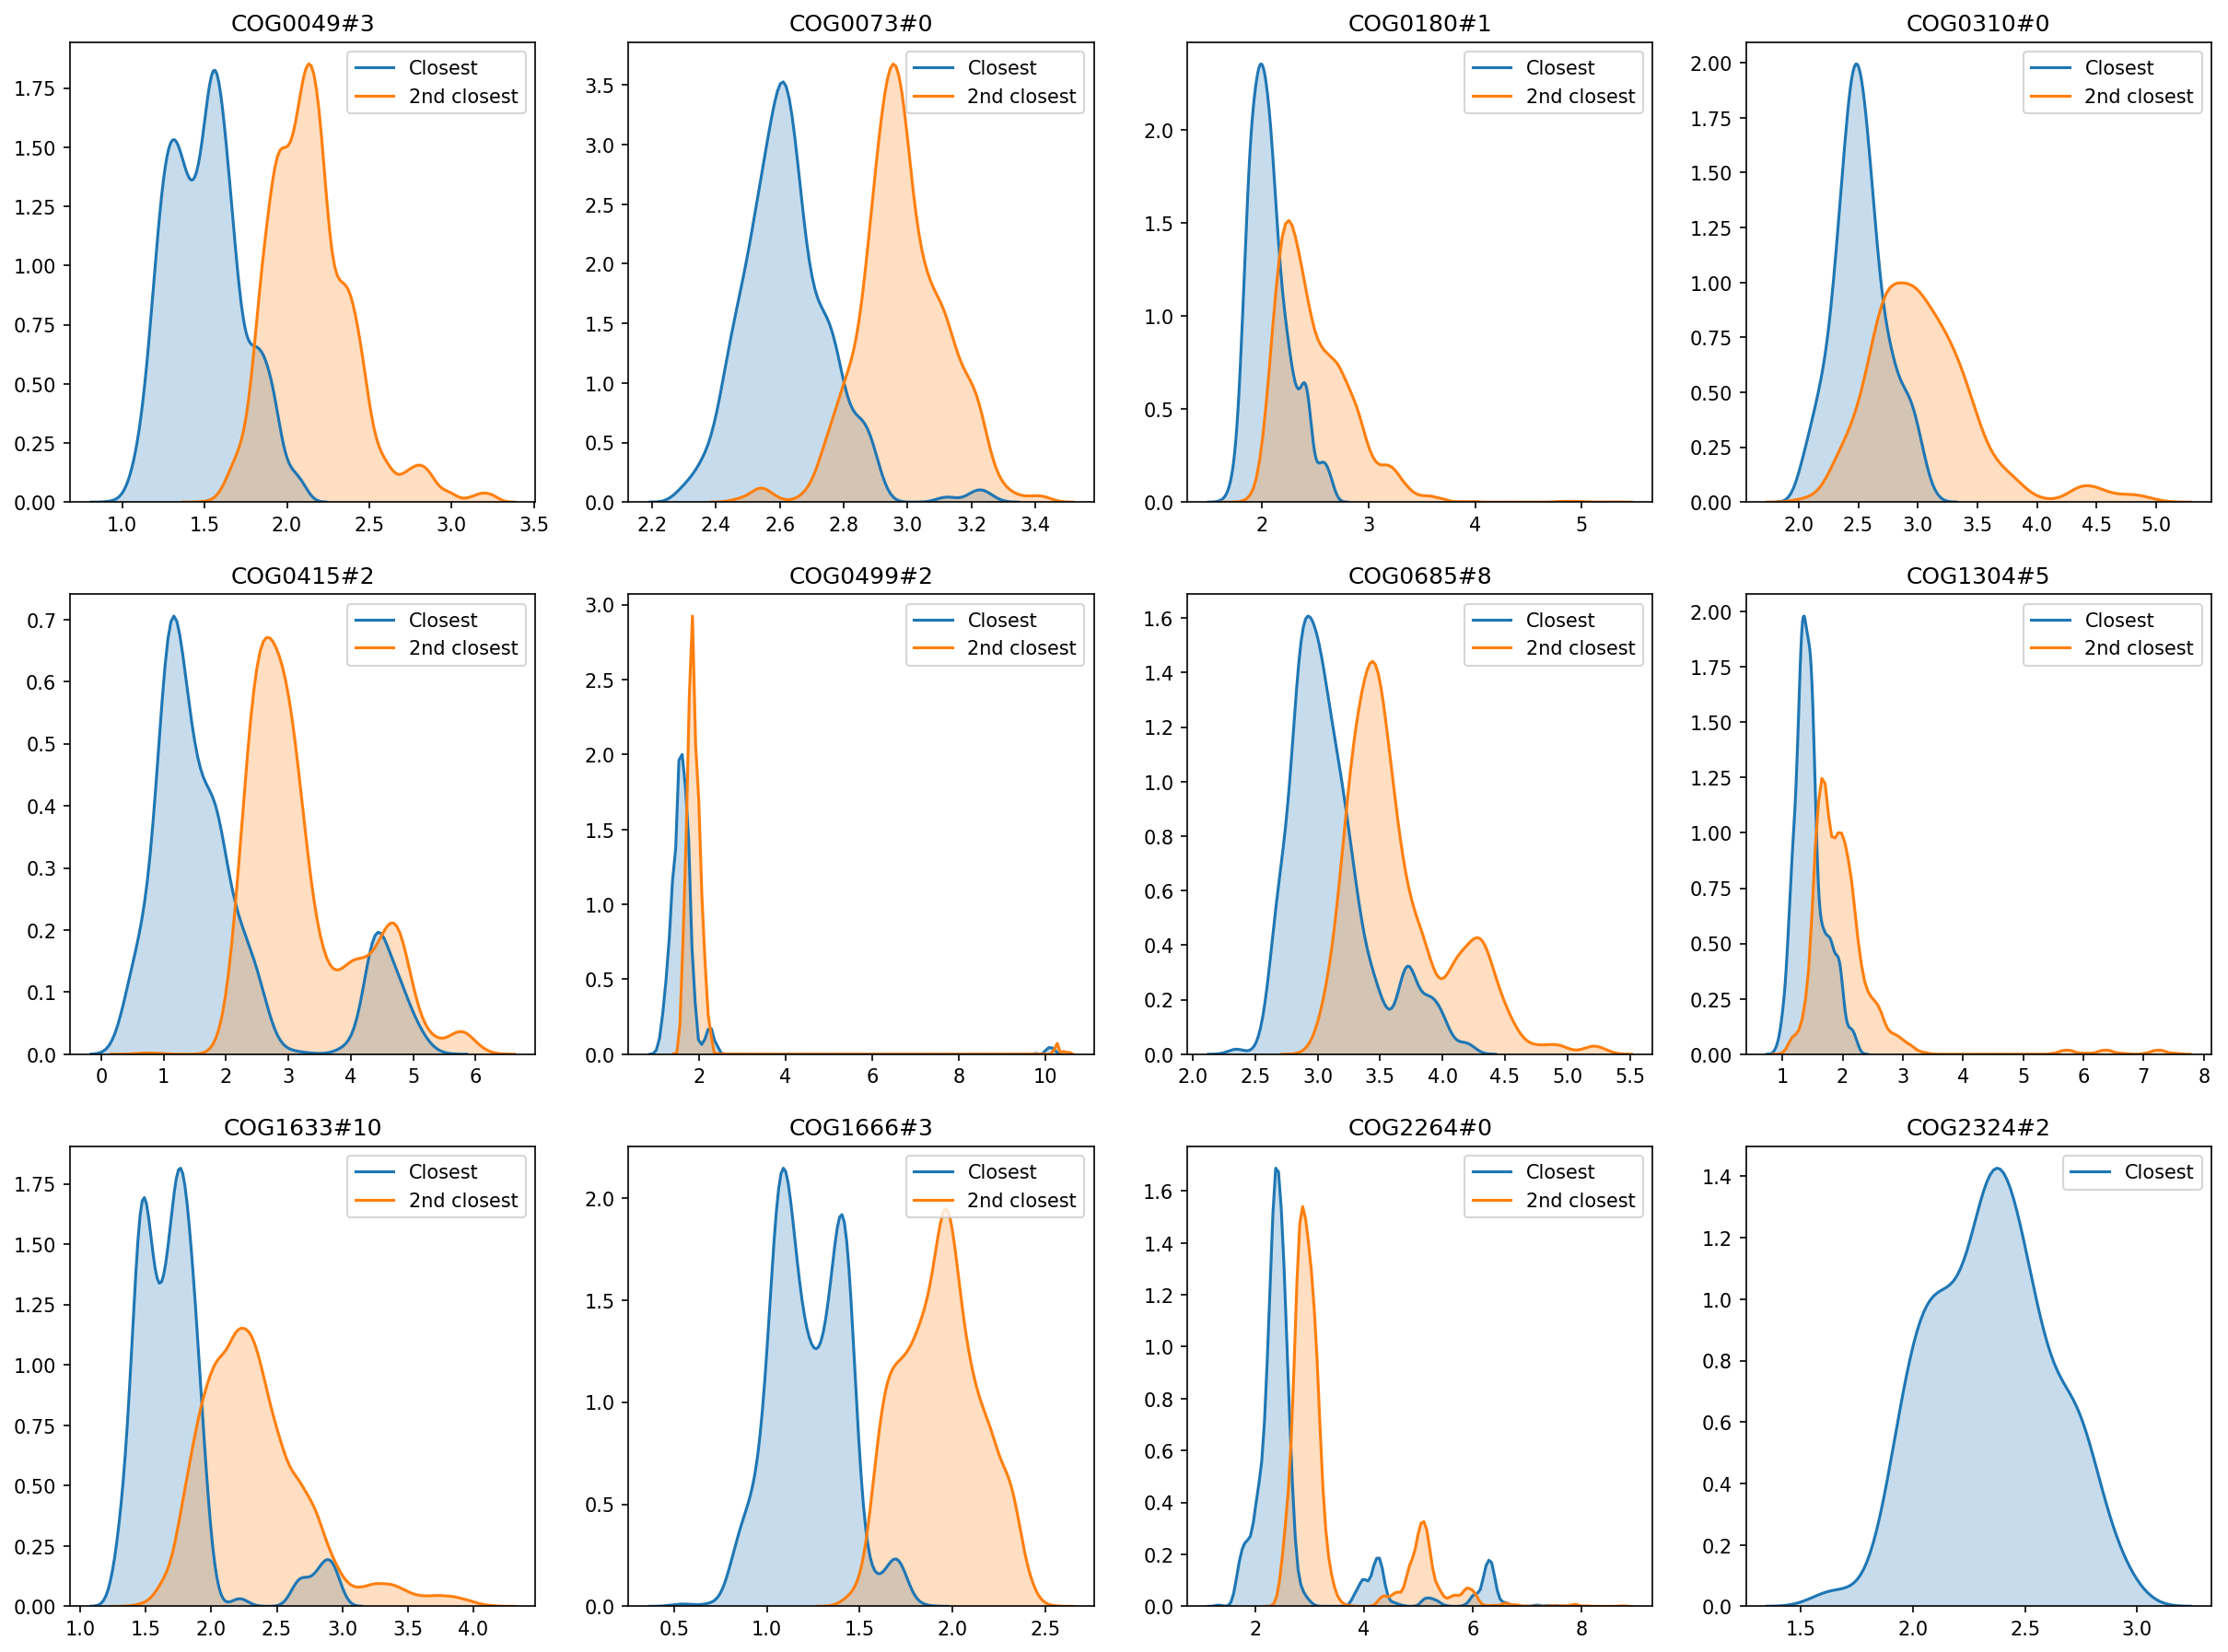

In [247]:
hell = []
yeah = []
closest_phyla = []

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), dpi=150)
axs = list(itertools.chain(*axs))
counter  = 0

for groupID, cluster_data in results.get():
    for cluster_num, cluster_dists in cluster_data.items():
        if not cluster_dists.shape[0]:
            continue

        cluster_dists.sort_values('median',
                                  inplace=True)
        closest_phyla.append(cluster_dists.iloc[0, 0])
        
        if cluster_dists.iloc[0, 0] != 200795:
            if 200795 in cluster_dists.phylum.values:
                hell.append(cluster_dists.loc[cluster_dists.phylum==200795, 
                                              'median'].squeeze())
            continue
        
        only_cyano_and_chloro = False
        try:
            hypothesis_test = mannwhitneyu(cluster_dists.iloc[0, 2],
                                           cluster_dists.iloc[1, 2],
                                           alternative='less')
        except IndexError:
            only_cyano_and_chloro = True

        effect_size = 0.5
        if hypothesis_test.pvalue < 0.01 and not only_cyano_and_chloro:
            effect_size = hypothesis_test.statistic / (cluster_dists.iloc[0, 2].shape[0]*\
                                                       cluster_dists.iloc[1, 2].shape[0])
        
        if effect_size < 0.15 or only_cyano_and_chloro:
            print('%s#%i' % (groupID, cluster_num))
            yeah.append(cluster_dists.iloc[0, 1])

            axs[counter].set_title('%s#%i' % (groupID, cluster_num))
            sns.kdeplot(cluster_dists.iloc[0, 2], shade=True, label='Closest', ax=axs[counter])
            if not only_cyano_and_chloro:
                sns.kdeplot(cluster_dists.iloc[1, 2], shade=True, label='2nd closest', ax=axs[counter])
            counter += 1
#         else:
#             print('')

In [19]:
candidates = 'COG0049#3  COG0073#0 COG0180#1 COG0310#0\
              COG0415#2  COG0499#2 COG0685#8 COG1304#5\
              COG1633#10 COG1666#3 COG2264#0 COG2324#2'

In [20]:
for candidate in candidates.split():
    print(candidate)
    visualize_candidates(candidate)

COG0049#3
  mafft --auto --reorder alignment/COG0049-cluster3.faa
  /Users/thiberio/anaconda2/bin/FastTree -gamma -wag -out alignment/COG0049-cluster3.tree alignment/COG0049-cluster3.aln
COG0073#0
  mafft --auto --reorder alignment/COG0073-cluster0.faa
  /Users/thiberio/anaconda2/bin/FastTree -gamma -wag -out alignment/COG0073-cluster0.tree alignment/COG0073-cluster0.aln
COG0180#1
  mafft --auto --reorder alignment/COG0180-cluster1.faa
  /Users/thiberio/anaconda2/bin/FastTree -gamma -wag -out alignment/COG0180-cluster1.tree alignment/COG0180-cluster1.aln
COG0310#0
  mafft --auto --reorder alignment/COG0310-cluster0.faa
  /Users/thiberio/anaconda2/bin/FastTree -gamma -wag -out alignment/COG0310-cluster0.tree alignment/COG0310-cluster0.aln
COG0415#2
  mafft --auto --reorder alignment/COG0415-cluster2.faa
  /Users/thiberio/anaconda2/bin/FastTree -gamma -wag -out alignment/COG0415-cluster2.tree alignment/COG0415-cluster2.aln
COG0499#2
  mafft --auto --reorder alignment/COG0499-cluster2.faa

In [ ]:
print('yeah')

In [221]:
for i, j in results.get():
    if i == 'COG0499':
        break

In [171]:
j[2].sort_values('median', inplace=True)

In [172]:
j[2]

,phylum,median,distances
4,200795,1.588374,"[0.9986413000000001, 1.0242645000000001, 1.034..."
8,200783,1.853747,"[1.5208204999999997, 1.5239896000000002, 1.537..."
9,200940,1.913207,"[1.6411704000000005, 1.6508458000000004, 1.666..."
5,-9223372036854775808,1.974896,"[1.1712678000000003, 1.196891, 1.2073736, 1.21..."
6,508458,2.916957,"[2.4532542000000004, 2.4788774000000005, 2.480..."
3,1239,3.072651,"[1.9503405000000003, 1.9759637000000003, 1.986..."
7,200918,3.411421,"[2.9716300000000007, 2.9717899033000004, 2.971..."
2,201174,4.503246,"[1.6267964000000004, 1.6524196000000004, 1.654..."
1,1224,5.981892,"[1.5345805000000006, 1.5602037000000006, 1.570..."
0,976,9.397056,"[2.2657185, 2.2913417000000003, 2.3018243, 2.3..."


In [167]:
a, b = get_phyla_evol_distances('COG0499')

In [98]:
c = b[0]

In [111]:
c['1st_quart'] = c.distances.apply(lambda x: np.percentile(x, 25))

In [130]:
c.sort_values('median', inplace=True)

In [190]:
mannwhitneyu(c.iloc[0, 2], c.iloc[1, 2], alternative='less')

MannwhitneyuResult(statistic=2965512.0, pvalue=2.3761368986950075e-11)

In [140]:
ttest_ind(c.iloc[0, 2], c.iloc[1, 2])

Ttest_indResult(statistic=-7.057182032649298, pvalue=1.9227590974550497e-12)

In [129]:
c.sort_values('median')

,phylum,median,distances,1st_quart
9,200795,1.546443,"[1.0056129999999999, 1.0418922, 1.0598625, 1.0...",1.434805
10,976,1.564379,"[1.0869564999999999, 1.1030696, 1.1142252, 1.1...",1.463121
12,200783,1.643917,"[1.1047206899999997, 1.1091097999999997, 1.129...",1.492280
7,57723,1.663563,"[0.6698852999999998, 0.9029992, 0.975935499999...",1.532397
11,1090,1.682052,"[1.2654312999999995, 1.3017104999999995, 1.328...",1.592857
6,1297,1.792493,"[1.2004175999999998, 1.2366967999999994, 1.254...",1.677201
13,203682,1.816875,"[0.746359, 0.7468291999999999, 0.8805971999999...",1.563938
2,1239,1.922252,"[0.9970439999999998, 1.0333231999999999, 1.079...",1.745068
8,201174,2.100163,"[0.7200895999999997, 0.761882, 0.7633225999999...",1.925711
4,74201,2.244619,"[1.4270055999999998, 1.4546064999999997, 1.463...",2.086386


In [128]:
c.sort_values('1st_quart')

,phylum,median,distances,1st_quart
9,200795,1.546443,"[1.0056129999999999, 1.0418922, 1.0598625, 1.0...",1.434805
10,976,1.564379,"[1.0869564999999999, 1.1030696, 1.1142252, 1.1...",1.463121
12,200783,1.643917,"[1.1047206899999997, 1.1091097999999997, 1.129...",1.492280
7,57723,1.663563,"[0.6698852999999998, 0.9029992, 0.975935499999...",1.532397
13,203682,1.816875,"[0.746359, 0.7468291999999999, 0.8805971999999...",1.563938
11,1090,1.682052,"[1.2654312999999995, 1.3017104999999995, 1.328...",1.592857
6,1297,1.792493,"[1.2004175999999998, 1.2366967999999994, 1.254...",1.677201
2,1239,1.922252,"[0.9970439999999998, 1.0333231999999999, 1.079...",1.745068
8,201174,2.100163,"[0.7200895999999997, 0.761882, 0.7633225999999...",1.925711
4,74201,2.244619,"[1.4270055999999998, 1.4546064999999997, 1.463...",2.086386


In [125]:
extract_cluster('COG0021#0')

In [89]:
Counter(closest_phyla)

Counter({1224: 68,
         40117: 9,
         200783: 37,
         200918: 20,
         57723: 49,
         200795: 196,
         32066: 32,
         200940: 56,
         1090: 34,
         200930: 40,
         508458: 38,
         203691: 18,
         201174: 36,
         203682: 45,
         204428: 16,
         976: 28,
         74201: 34,
         1297: 91,
         544448: 4,
         1936987: 3,
         142182: 6,
         1239: 44,
         -9223372036854775808: 17,
         1134404: 5,
         67814: 1,
         67819: 4,
         200938: 2})

In [84]:
len(closest_phyla)

933

In [143]:
c

,phylum,median,distances,1st_quart
9,200795,1.546443,"[1.0056129999999999, 1.0418922, 1.0598625, 1.0...",1.434805
10,976,1.564379,"[1.0869564999999999, 1.1030696, 1.1142252, 1.1...",1.463121
12,200783,1.643917,"[1.1047206899999997, 1.1091097999999997, 1.129...",1.492280
7,57723,1.663563,"[0.6698852999999998, 0.9029992, 0.975935499999...",1.532397
11,1090,1.682052,"[1.2654312999999995, 1.3017104999999995, 1.328...",1.592857
6,1297,1.792493,"[1.2004175999999998, 1.2366967999999994, 1.254...",1.677201
13,203682,1.816875,"[0.746359, 0.7468291999999999, 0.8805971999999...",1.563938
2,1239,1.922252,"[0.9970439999999998, 1.0333231999999999, 1.079...",1.745068
8,201174,2.100163,"[0.7200895999999997, 0.761882, 0.7633225999999...",1.925711
4,74201,2.244619,"[1.4270055999999998, 1.4546064999999997, 1.463...",2.086386


0.44691478587962963

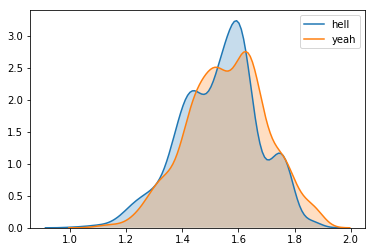

In [219]:
hell = c.iloc[0, 2]
yeah = c.iloc[1, 2]

fig, ax = plt.subplots()
sns.kdeplot(hell, shade=True, label='hell')
sns.kdeplot(yeah, shade=True, label='yeah')

t = mannwhitneyu(hell, yeah)
t.statistic/(len(hell)*len(yeah))

0.1378066890495868

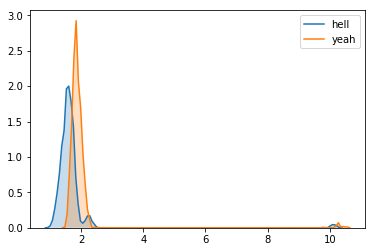

In [223]:
hell = j[2].iloc[0, 2]
yeah = j[2].iloc[1, 2]

fig, ax = plt.subplots()
sns.kdeplot(hell, shade=True, label='hell')
sns.kdeplot(yeah, shade=True, label='yeah')

t = mannwhitneyu(yeah, hell)
t.statistic/(len(hell)*len(yeah))

In [76]:
len(hell), len(yeah)  

(506, 167)

In [77]:
np.min(hell), np.min(yeah)

(1.0151929694999997, 0.7724393586000005)

In [ ]:
for group_id in test_groups.group_id.to_list():
# for group_id in ['COG0499']:
    print(group_id)
    
    dist_matrix = get_pairwise_distances(group_id)

    taxids = [int(leaf.split('.')[0]) for leaf in dist_matrix.index]
    phyla  = eggNOG_lineage.loc[taxids, 'phylum'].values.astype(int)

    edge_list, graph  = create_taxa_graph(dist_matrix, phyla)

    clusters = graph.community_multilevel(weights='weight')

    node_data = pd.DataFrame(columns=['name', 'phylum', 'cluster'],
                             data   =zip(dist_matrix.index, 
                                         phyla, 
                                         clusters.membership)
                            )

    family_cyano_count = sum(node_data.phylum==1117)
    
    cluster_evol_relations = {}

    for cluster_num in set(clusters.membership):
        cluster_nodes = node_data[node_data.cluster==cluster_num]

        if sum(cluster_nodes.phylum==1117) < family_cyano_count*0.3:
            continue

        cluster_dists = pd.DataFrame(columns=['phylum', 'median', 'distances'])
        
        cluster_edges = edge_list.loc[(edge_list.sequence1.isin(cluster_nodes.name))&
                                      (edge_list.sequence2.isin(cluster_nodes.name)),
                                      ['phylum1', 'phylum2', 'distance']]

        minimal_freq_phyla = [phylum for phylum, frequency in Counter(cluster_nodes.phylum).items() if frequency>=5]
        cluster_edges      = cluster_edges[(cluster_edges.phylum1.isin(minimal_freq_phyla)) &\
                                           (cluster_edges.phylum2.isin(minimal_freq_phyla))]
        normalizer         = np.median(cluster_edges.distance)
        cluster_edges      = cluster_edges[cluster_edges.phylum1 != cluster_edges.phylum2] 

        threshold      = np.infty
        closest_phylum = None
        for phylum1, phylum2 in itertools.combinations(minimal_freq_phyla, 2):
            if indices.shape[0] < 10:
                continue
            if   phylum1 == 1117:
                phylum = phylum2
            elif phylum2 == 1117:
                phylum = phylum1
            else:
                continue

            inter_phyla_dists = cluster_edges.loc[((cluster_edges.phylum1==phylum1)&(cluster_edges.phylum2==phylum2))|\
                                                  ((cluster_edges.phylum2==phylum1)&(cluster_edges.phylum1==phylum2)), 
                                                  'distance'].values
            inter_phyla_dists.sort()

            try:
                phylum_3rd_quartile = np.median(inter_phyla_dists)
            except IndexError:
                continue        

            cluster_dists = cluster_dists.append(pd.Series(data=[phylum, phylum_3rd_quartile, inter_phyla_dists], 
                                               index=['phylum', 'median', 'distances']),
                                     ignore_index=True)

        cluster_evol_relations[cluster_num] = cluster_dists
    
    return(group_id, cluster_evol_relations)

In [ ]:
yeah = deepcopy(phyla_closeness[200795])

In [ ]:
for n in closest_data.loc[closest_data.phylum==200795, 'closeness'].values:
    yeah.remove(n)

In [ ]:
np.min(yeah)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5), dpi=300)

sns.kdeplot(closest_data.loc[closest_data.phylum==200795, 'closeness'], label='Closest', shade=True, ax=ax)
sns.kdeplot(yeah, label='Not closest', shade=True, ax=ax)

In [ ]:
%%time
#
# test specific families
#
dist_matrix = get_pairwise_distances('COG2343')

taxids = [int(leaf.split('.')[0]) for leaf in dist_matrix.index]
phyla  = eggNOG_lineage.loc[taxids, 'phylum'].values.astype(int)

edge_list, graph  = create_taxa_graph(dist_matrix, phyla)

clusters = graph.community_multilevel(weights='weight')

node_data = pd.DataFrame(columns=['name', 'phylum', 'cluster'],
                         data   =zip(dist_matrix.index, 
                                     phyla, 
                                     clusters.membership)
                        )

family_cyano_count = sum(node_data.phylum==1117)

for cluster_num in set(clusters.membership):
    print(cluster_num)
    cluster_nodes = node_data[node_data.cluster==cluster_num]
    
    cluster_dists = pd.DataFrame(columns=['phylum', '3rd_quartile', 'distances'])

    if sum(cluster_nodes.phylum==1117) < family_cyano_count*0.3:
        continue

    cluster_edges = edge_list.loc[(edge_list.sequence1.isin(cluster_nodes.name))&
                                  (edge_list.sequence2.isin(cluster_nodes.name)),
                                  ['phylum1', 'phylum2', 'distance']]

    minimal_freq_phyla = [phylum for phylum, frequency in Counter(cluster_nodes.phylum).items() if frequency>=5]
    cluster_edges      = cluster_edges[(cluster_edges.phylum1.isin(minimal_freq_phyla)) &\
                                       (cluster_edges.phylum2.isin(minimal_freq_phyla))]
    normalizer         = np.median(cluster_edges.distance)
    cluster_edges      = cluster_edges[cluster_edges.phylum1 != cluster_edges.phylum2] 
    
    threshold      = np.infty
    closest_phylum = None
    for phylum1, phylum2 in itertools.combinations(minimal_freq_phyla, 2):
        if indices.shape[0] < 10:
            continue
            
        if   phylum1 == 1117:
            phylum = phylum2
        elif phylum2 == 1117:
            phylum = phylum1
        else:
            continue
            
        inter_phyla_dists = cluster_edges.loc[((cluster_edges.phylum1==phylum1)&(cluster_edges.phylum2==phylum2))|\
                                              ((cluster_edges.phylum2==phylum1)&(cluster_edges.phylum1==phylum2)), 
                                              'distance'].values

        inter_phyla_dists.sort()

        try:
            phylum_3rd_quartile = np.percentile(inter_phyla_dists, 25)
        except IndexError:
            continue        
        
        cluster_dists = cluster_dists.append(pd.Series(data=[phylum, phylum_3rd_quartile, inter_phyla_dists], 
                                                       index=['phylum', '3rd_quartile', 'distances']),
                                             ignore_index=True)
        if phylum_3rd_quartile < threshold:
            threshold      = phylum_3rd_quartile
            closest_phylum = phylum

    if closest_phylum:
        print('  Closest to cyanos: %s (%.4f)' % (closest_phylum, threshold/normalizer))

In [ ]:
cluster_dists

In [ ]:
cluster_nodes = node_data[node_data.cluster==0]

In [ ]:
cluster_nodes[cluster_nodes.phylum==200795]

In [ ]:
cluster_nodes.head()

In [ ]:
alignment_data = []

with open('alignment/COG2343.faa', 'r') as handle:
    for entry in handle.read().split('>'):
        if entry:
            entry = entry.strip()
            alignment_data.append(entry.split('\n'))

alignment_df = pd.DataFrame(columns=['header', 'sequence'],
                            data   =alignment_data)

In [ ]:
with open('alignment/COG2343-cluster2.faa', 'w') as out:
    for index, item in alignment_df[alignment_df.header.isin(cluster_nodes.name)].iterrows():
        out.write('>%s\n%s\n' % (item.header, item.sequence))

In [ ]:
fig, ax = plt.subplots()
sns.kdeplot(phyla_closeness[200795], shade=True, ax=ax)
ax.fill_between(x=[0.3478], y1=ax.get_ylim()[0], y2=ax.get_ylim()[1], color='r')

In [64]:
def visualize_in_figTree(group_id):
    tree = ete3.Tree(eggNOG_trees.loc[group_id, 'tree'], format=0)
    
    out  = open('%s.figTree' % group_id, 'w')
    out.write("#NEXUS\nbegin taxa;\n\tdimensions ntax=%i;\n\ttaxlabels\n" %len(tree))
    
    for node in tree.traverse():
        if node.is_leaf():
            taxid, locus_tag = node.name.split('.')
            try:
                lineage = {j: i for i, j in ncbi.get_rank(ncbi.get_lineage(taxid)).items()}
            except ValueError:
                out.write('\t%s\n' %(node.name))
                continue
            else:
                lineage_names = ncbi.get_taxid_translator(lineage.values())

            out.write('\t%s ' %(node.name))
            comment = []
            for rank in ['class', 'phylum', 'order', 'family', 'species']:
                if rank in lineage:
                    comment.append('tax_%s="%s"' %(rank, lineage_names[lineage[rank]]))
            out.write('[&%s]\n' %' '.join(comment))

    newick_text = tree.write(format=0)
    out.write(';\nend;\n')
    out.write('begin trees;\n\ttree tree_1 = [&R] %s\nend;' %newick_text)
    out.close()

In [65]:
visualize_in_figTree('COG0073')

In [249]:
tree = ete3.Tree('alignment/COG0049-cluster3.tree', format=0)

out  = open('COG0049-cluster3.fastFigTree', 'w')
out.write("#NEXUS\nbegin taxa;\n\tdimensions ntax=%i;\n\ttaxlabels\n" %len(tree))

for node in tree.traverse():
    if node.is_leaf():
        taxid, locus_tag = node.name.split('.')
        try:
            lineage = {j: i for i, j in ncbi.get_rank(ncbi.get_lineage(taxid)).items()}
        except ValueError:
            out.write('\t%s\n' %(node.name))
            continue
        else:
            lineage_names = ncbi.get_taxid_translator(lineage.values())

        out.write('\t%s ' %(node.name))
        comment = []
        for rank in ['class', 'phylum', 'order', 'family', 'species']:
            if rank in lineage:
                comment.append('tax_%s="%s"' %(rank, lineage_names[lineage[rank]]))
        out.write('[&%s]\n' %' '.join(comment))

newick_text = tree.write(format=0)
out.write(';\nend;\n')
out.write('begin trees;\n\ttree tree_1 = [&R] %s\nend;' %newick_text)
out.close()